In [2]:
#Import packages
import pandas as pd
import numpy as np

#To plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [5]:
#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [6]:
#read the file
df = pd.read_csv('C:/Users/18579/Desktop/data/Stock price prediction/NSE-TATAGLOBAL11.csv')

#print the head
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


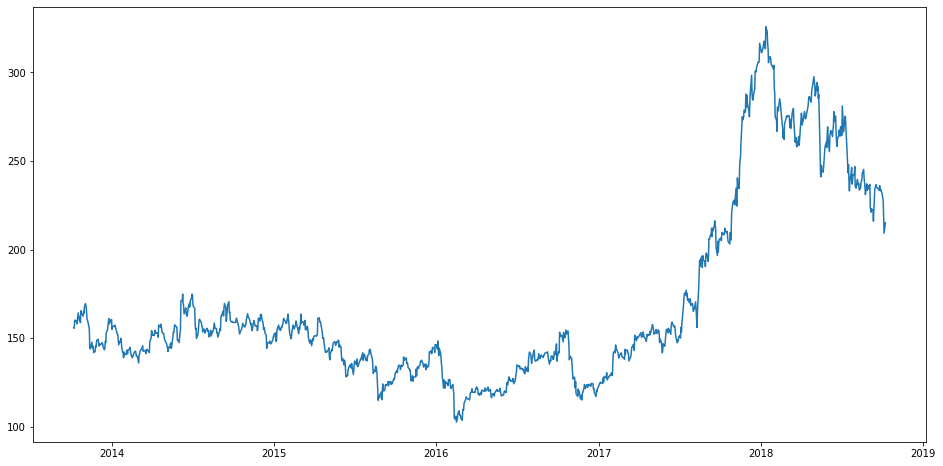

In [7]:
#setting index as date
import warnings
warnings.filterwarnings("ignore")

df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [2]:
pip install pmdarima

  Using cached https://files.pythonhosted.org/packages/83/55/a0f0a5f4cda1baae4c0af95e11209c2d62fe65e4aef5397060140b661155/pmdarima-1.3.0-cp37-cp37m-win_amd64.whl
Note: you may need to restart the kernel to use updated packages.


# Using Auto ARIMA Model

In [11]:
from pmdarima.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = data[:987]
valid = data[987:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=248)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4820.561, BIC=4844.968, Fit time=26.936 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5479.245, BIC=5489.008, Fit time=0.173 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5170.275, BIC=5189.801, Fit time=4.808 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4818.530, BIC=4838.055, Fit time=15.429 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4816.433, BIC=4840.840, Fit time=12.300 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=5170.276, BIC=5189.801, Fit time=4.212 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=4818.340, BIC=4847.629, Fit time=62.590 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=5481.156, BIC=5495.800, Fit time=1.064 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=4818.627, BIC=4852.797, Fit time=47.653 seconds
Fit ARIMA: order=(1, 1,

In [12]:
#Result
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

44.952951891703016

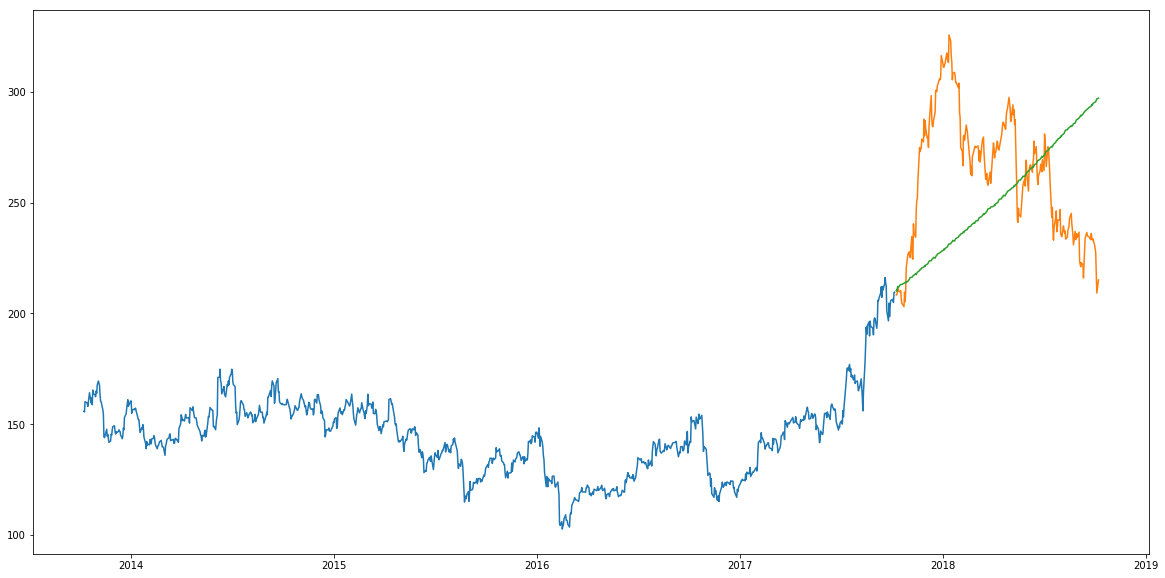

In [13]:
#plot
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

# Long short Term Memory

In [9]:
#importing required libraries
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Epoch 1/1
 - 335s - loss: 9.6616e-04


In [10]:
#Results
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

19.331434088506068

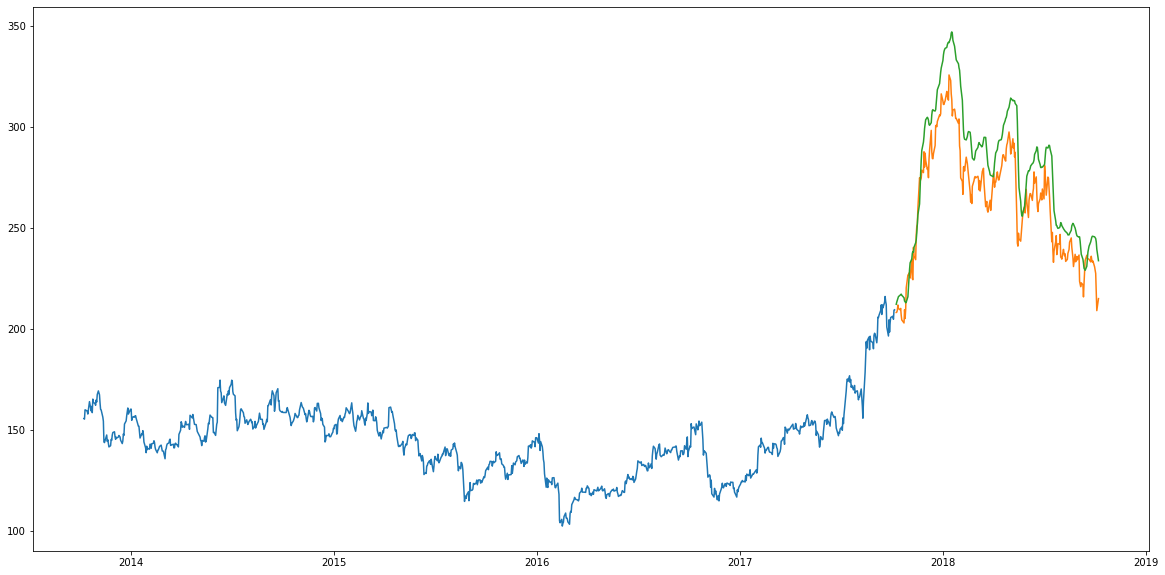

In [11]:
#for plotting modelled output
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])